### Libraries

In [7]:
# LOAD LIBRARIES
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random


# Load libraries for Decision Tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import scale

# Load libraries for Decision Tree Model Plot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

# Load libaries for various model performance metrics
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, accuracy_score
from matplotlib import pyplot as plt
from inspect import signature

# Load libaries for logistic regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from scipy.spatial import distance

import matplotlib.pyplot as plt 
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

### Import and Cleaning data

In [8]:
def get_census_data(path_train, path_test):
    # import:
    columns = [
        "age", "workClass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country",
        "income"
    ]
    census_train = pd.read_csv(path_train,
                               names=columns,
                               sep=' *, *',
                               na_values='?')
    census_test = pd.read_csv(path_test,
                              names=columns,
                              sep=' *, *',
                              skiprows=1,
                              na_values='?')

    census = pd.concat([census_train, census_test], axis=0)

    # clean:
    census['income'] = census['income'].map(lambda x: x.replace('.', ''))

    census['income_over_50K'] = None
    census.loc[census.income == '<=50K', 'income_over_50K'] = 0
    census.loc[census.income == '>50K', 'income_over_50K'] = 1

    income_over_50K = census.income_over_50K
    census = census.drop(columns=['income_over_50K', 'income'])
    census.insert(0, 'income_over_50K', income_over_50K)

    census = census.drop(columns = ['fnlwgt']) # does not have anything to do with data

    # Making native-country to country_USA feature instead:
    census['country_USA'] = 0
    census.loc[census['native-country'] == 'United-States', 'country_USA'] = 1
    census = census.drop(columns=['native-country'])
    
    census = census.reset_index().drop(columns=['index'])
    
    census_with_dummies = pd.get_dummies(data= census,columns=census.select_dtypes(include=['object']).columns,drop_first=True)

    return census, census_with_dummies

def explore_data(data, label):
    num_attributes = data.select_dtypes(include=['int'])
    print('Numerical features: ' + str(num_attributes.columns))

    num_attributes.hist(figsize=(10,10))

    print(data.describe())

    cat_attributes = data.select_dtypes(include=['object'])
    print('Categorical features: ' + str(cat_attributes.columns))

    for column in cat_attributes:
        if column != 'income':
            sns.countplot(y=column, hue=data[label], data = cat_attributes)
            plt.show()

### Setting global defaults

In [43]:
class Experiment():
    # Defaults:
    FRACTIONS = {
    'labeled_keep': 0.005,
    'labeled_delete': 0.00,
    'unlabeled': 0.695,
    'unknown': 0.3
    }
    SEED = 1
    PCT_TO_LABEL = 0.05
    
    def __init__(self, unsplit_data, seed = SEED):
        self.unsplit_data = unsplit_data
        self.seed = seed
        
        self.split_data = Experiment.divide_data(unsplit_data, seed = self.seed)
        
        self.labeled_initial = pd.concat(
            [self.split_data['labeled_keep'], self.split_data['labeled_delete']], axis=0)
        
        self.X_initial, self.y_initial = Experiment.get_X_y(self.labeled_initial)

        

    def divide_data(unsplit_data, fractions = FRACTIONS, seed = SEED):
        '''
        divides data into labeled_keep, labeled_delete, unlabeled and unknown
        '''
        split_data = {}
        n_rows = unsplit_data.shape[0]
        remaining = unsplit_data.copy()

        for key in fractions:
            n_rows_key = int(np.floor(fractions[key] * n_rows))
            split_data[key] = remaining.sample(n=n_rows_key, random_state = seed)

            remaining = remaining.drop(split_data[key].index)

        return split_data
    
    
    def KNN_cv(X, y, k_range = range(1, 30, 2)):
        '''
        finds best K for KNN
        '''
        k_scores = []

        # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
        for k in k_range:
            print('k = ' + str(k))
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
            k_scores.append(scores.mean())

        # plot to see clearly
        plt.plot(k_range, k_scores)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Cross-Validated Accuracy')
        plt.show()

        best_k = k_scores.index((max(k_scores))) + 1

        return best_k
    
    def compare_models(m1, m2, data):
        m1_accuracy = Experiment.get_model_accuracy(m1, data)
        m2_accuarcy = Experiment.get_model_accuracy(m2, data)

        return m1_accuracy, m2_accuarcy
    
    def get_model_accuracy(m, data):
        X, y = Experiment.get_X_y(data)

        y_pred = m.predict(X)

        return accuracy_score(y, y_pred)

    def get_X_y(df):
        '''
        Returns first column of df as y and rest as X
        '''
        X = df.drop(df.columns[0], axis=1)   
        y = df.iloc[:, 0]

        return X, y
    
    def random_active_learning(split_data, pct_unlabel_to_label, seed):
        n_points_to_add = int(np.floor(split_data['unlabeled'].shape[0] * pct_unlabel_to_label))

        unlabeled = split_data['unlabeled'].copy()
        labeled = pd.concat([split_data['labeled_keep'], split_data['labeled_delete']], axis=0)

        newly_labeled = unlabeled.sample(n=n_points_to_add, random_state = seed)
        remaining_unlabeled = unlabeled.drop(newly_labeled.index)
        labeled = labeled.append(newly_labeled)

        return labeled
    
    def uncertainty_active_learning(split_data, pct_to_label = PCT_TO_LABEL, seed = SEED):
        newly_labeled = pd.DataFrame(columns=split_data['unlabeled'].columns)
        unlabeled = split_data['unlabeled'].copy()

        for i in range(5):
            print(i)

            X_unlabled = unlabeled.drop(labeled.columns[0], axis=1)

            proba_class_1 = current_model.predict_proba(X_unlabled)[:,1]

            #gives the length from probability 0.5, more length means more certainty
            X_unlabled['class_certainty'] = np.abs(proba_class_1 - 0.5)

            most_uncertain_rows_indexes = X_unlabled.class_certainty.sort_values().index[:n_points_to_add_at_a_time]

            #most_uncertain_row_index = X_unlabled.class_certainty.idxmin()

            rows_to_add = unlabeled.loc[most_uncertain_rows_indexes,:]


            newly_labeled = newly_labeled.append(rows_to_add)
            unlabeled = unlabeled.drop(most_uncertain_rows_indexes)
            labeled = labeled.append(rows_to_add)

            y = labeled.iloc[:, 0]
            X = labeled.drop(labeled.columns[0], axis=1)

            current_model.fit(X, y)
    
    def run_experiment(self,
                   pct_to_label = PCT_TO_LABEL,
                   method='random',
                   fractions=FRACTIONS):
        '''
        input raw data, output initial and final model accuracy
        '''
        #split_data = divide_data(unsplit_data, fractions, seeds)

        #labeled_initial = pd.concat(
        #    [split_data['labeled_keep'], split_data['labeled_delete']], axis=0)
        #X, y = get_X_y(labeled_initial)

        self.best_k_initial = Experiment.KNN_cv(self.X_initial, self.y_initial)

        self.model_initial = KNeighborsClassifier(n_neighbors=self.best_k_initial)
        self.model_initial.fit(self.X_initial, self.y_initial)

        if method == 'random':
            self.labeled_final = Experiment.random_active_learning(self.split_data,
                                                   pct_to_label, self.seed)
        elif method == 'uncertainty':
            print('tbd')

        self.X_final, self.y_final = Experiment.get_X_y(self.labeled_final)
        self.best_k_final = Experiment.KNN_cv(self.X_final, self.y_final)

        self.model_final = KNeighborsClassifier(n_neighbors=self.best_k_final)
        self.model_final.fit(self.X_final, self.y_final)

        self.model_initial_accuracy, self.model_final_accuracy = Experiment.compare_models(
            self.model_initial, self.model_final, self.split_data['unknown'])

        return self.model_initial_accuracy, self.model_final_accuracy


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


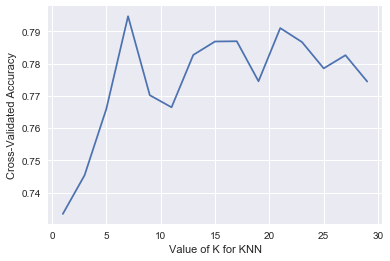

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


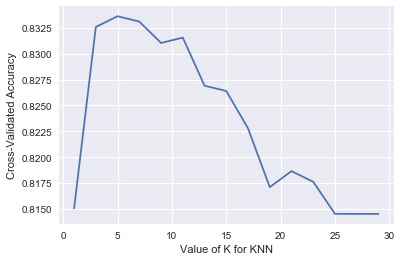

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


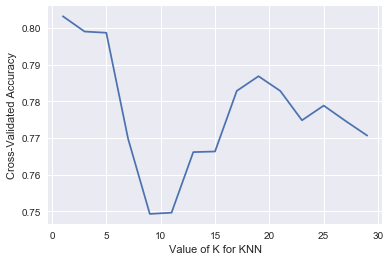

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


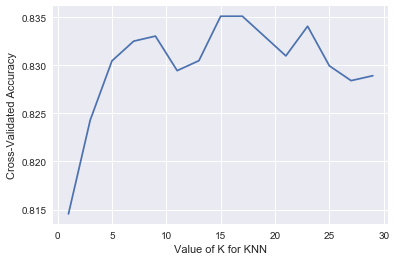

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


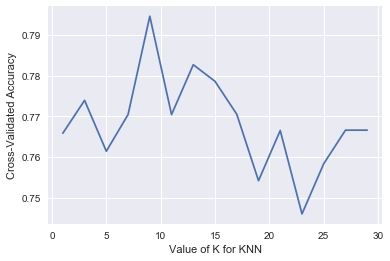

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


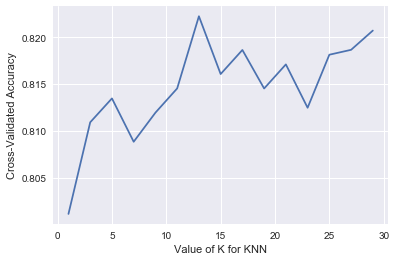

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


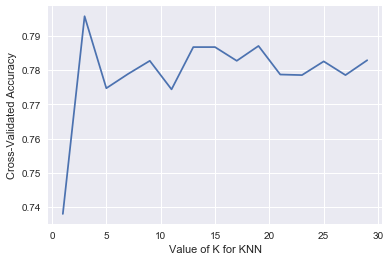

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


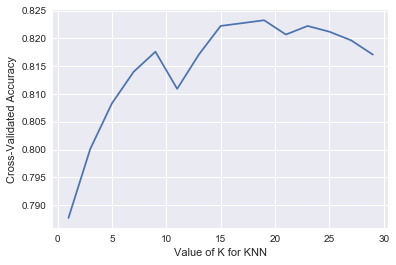

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


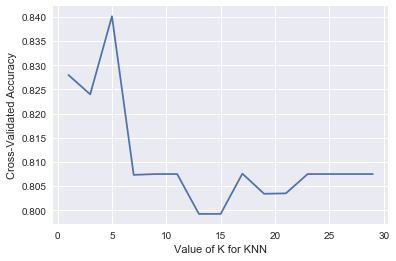

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


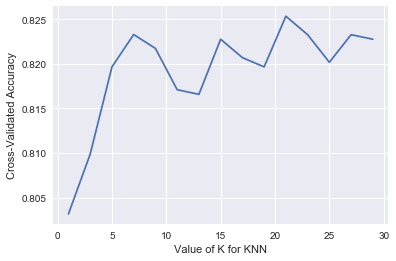

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


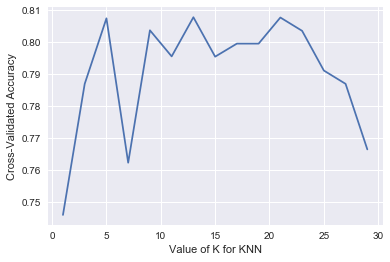

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


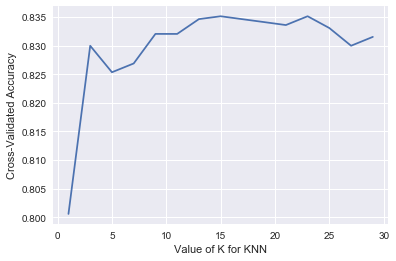

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


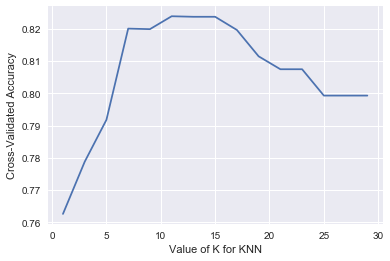

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


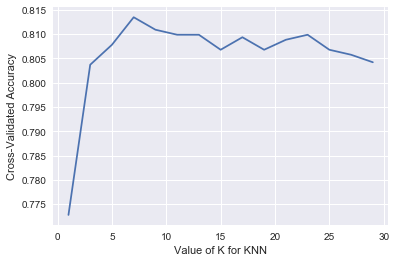

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


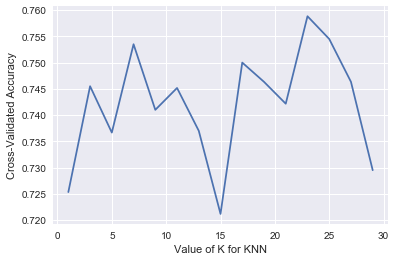

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


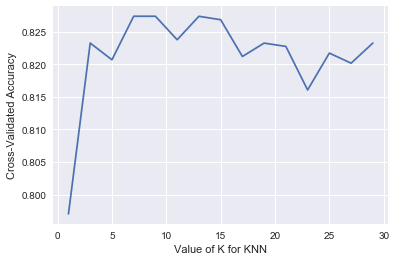

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


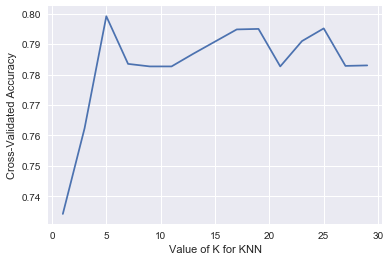

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


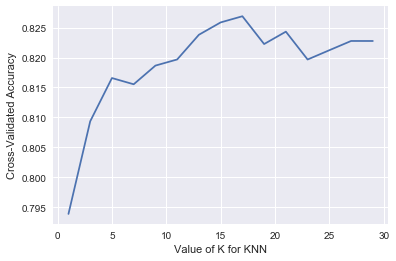

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


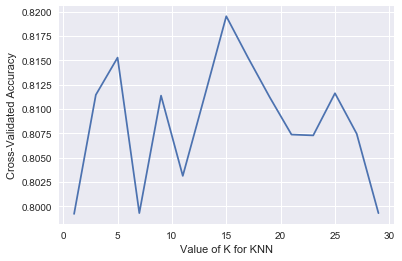

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


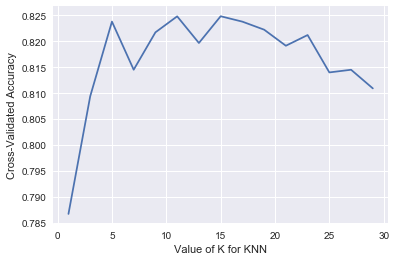

In [50]:
census, census_with_dummies = get_census_data('adult.data', 'adult.test')

experiments = []
initial_accuracy = []
final_accuracy = []
for i in range(10):
    experiments.append(Experiment(census_with_dummies, seed=i))
    experiments[i].run_experiment()
    initial_accuracy.append(experiments[i].model_initial_accuracy)
    final_accuracy.append(experiments[i].model_final_accuracy)

In [56]:
accuracy_increases = pd.Series(final_accuracy) - pd.Series(initial_accuracy)
np.mean(accuracy_increases)
np.var(accuracy_increases)

5.520560393615269e-05

In [40]:
FRACTIONS = {
    'labeled_keep': 0.005,
    'labeled_delete': 0.00,
    'unlabeled': 0.695,
    'unknown': 0.3
}

SEEDS = [1, 2, 3, 4]

PCT_TO_LABEL = 0.05

### Defining Methods

In [41]:
def divide_data(unsplit_data, fractions = FRACTIONS, seeds = SEEDS):
    '''
    divides data into labeled_keep, labeled_delete, unlabeled and unknown
    '''
    split_data = {}
    n_rows = unsplit_data.shape[0]
    remaining = unsplit_data.copy()
    seed_index = 0
    
    for key in fractions:
        n_rows_key = int(np.floor(fractions[key] * n_rows))
        split_data[key] = remaining.sample(n=n_rows_key, random_state = seeds[seed_index])
        
        seed_index += 1
        remaining = remaining.drop(split_data[key].index)
    
    return split_data

In [43]:
def KNN_cv(X, y, k_range = range(1, 30, 2)):
    '''
    finds best K for KNN
    '''
    k_scores = []

    # use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
    for k in k_range:
        print('k = ' + str(k))
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    
    # plot to see clearly
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    best_k = k_scores.index((max(k_scores))) + 1
    
    return best_k

In [35]:
def compare_models(m1, m2, data):
    m1_accuracy = get_model_accuracy(m1, data)
    m2_accuarcy = get_model_accuracy(m2, data)
        
    return m1_accuracy, m2_accuarcy
    
def get_model_accuracy(m, data):
    X, y = get_X_y(data)
    
    y_pred = m.predict(X)
    
    return accuracy_score(y, y_pred)

def get_X_y(df):
    '''
    Returns first column of df as y and rest as X
    '''
    X = df.drop(df.columns[0], axis=1)   
    y = df.iloc[:, 0]

    return X, y

In [34]:
def random_active_learning(split_data, pct_unlabel_to_label, seeds):
    n_points_to_add = int(np.floor(split_data['unlabeled'].shape[0] * pct_unlabel_to_label))
    
    unlabeled = split_data['unlabeled'].copy()
    labeled = pd.concat([split_data['labeled_keep'], split_data['labeled_delete']], axis=0)
    
    newly_labeled = unlabeled.sample(n=n_points_to_add, random_state = 1) #TODO: add seed
    remaining_unlabeled = unlabeled.drop(newly_labeled.index)
    labeled = labeled.append(newly_labeled)
    
    return labeled
    

In [ ]:
def uncertainty_active_learning(split_data, pct_unlabel_to_label, seeds):
    newly_labeled = pd.DataFrame(columns=split_data['unlabeled'].columns)
    unlabeled = split_data['unlabeled'].copy()

    for i in range(5):
        print(i)

        X_unlabled = unlabeled.drop(labeled.columns[0], axis=1)

        proba_class_1 = current_model.predict_proba(X_unlabled)[:,1]

        #gives the length from probability 0.5, more length means more certainty
        X_unlabled['class_certainty'] = np.abs(proba_class_1 - 0.5)

        most_uncertain_rows_indexes = X_unlabled.class_certainty.sort_values().index[:n_points_to_add_at_a_time]

        #most_uncertain_row_index = X_unlabled.class_certainty.idxmin()

        rows_to_add = unlabeled.loc[most_uncertain_rows_indexes,:]


        newly_labeled = newly_labeled.append(rows_to_add)
        unlabeled = unlabeled.drop(most_uncertain_rows_indexes)
        labeled = labeled.append(rows_to_add)

        y = labeled.iloc[:, 0]
        X = labeled.drop(labeled.columns[0], axis=1)

        current_model.fit(X, y)

In [44]:
def run_experiment(unsplit_data,
                   pct_unlabel_to_label,
                   method='random',
                   fractions=FRACTIONS,
                   seeds=SEEDS):
    '''
    input raw data, output initial and final model accuracy
    '''
    split_data = divide_data(unsplit_data, fractions, seeds)

    labeled_initial = pd.concat(
        [split_data['labeled_keep'], split_data['labeled_delete']], axis=0)
    X, y = get_X_y(labeled_initial)

    best_k = KNN_cv(X, y)

    initial_model = KNeighborsClassifier(n_neighbors=best_k)
    initial_model.fit(X, y)

    if method == 'random':
        labeled_final = random_active_learning(split_data,
                                               pct_unlabel_to_label, seeds)
    elif method == 'uncertainty':
        print('tbd')

    X, y = get_X_y(labeled_final)
    final_best_k = KNN_cv(X, y)

    final_model = KNeighborsClassifier(n_neighbors=final_best_k)
    final_model.fit(X, y)

    initial_model_accuracy, final_model_accuracy = compare_models(
        initial_model, final_model, split_data['unknown'])

    return initial_model_accuracy, final_model_accuracy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [40]:
census, census_with_dummies = get_census_data('adult.data', 'adult.test')
exp = Experiment(census_with_dummies)
exp.run_experiment()

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


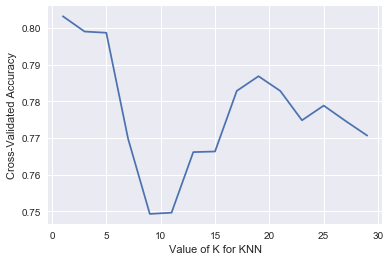

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


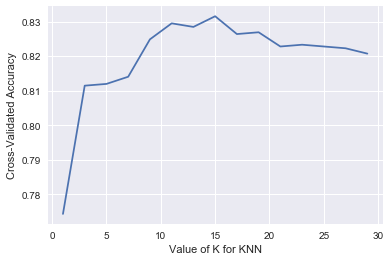

(0.7777095277095277, 0.822003822003822)

In [6]:
census, census_with_dummies = get_census_data('adult.data', 'adult.test')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


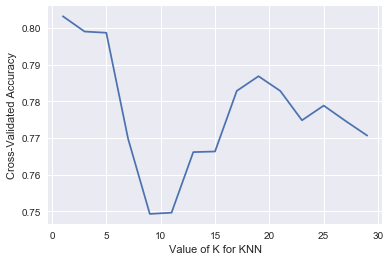

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


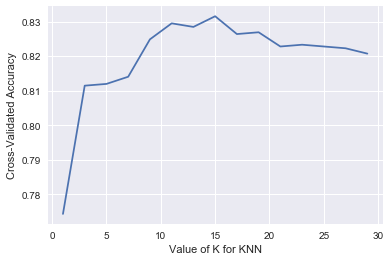

(0.7777095277095277, 0.822003822003822)

In [39]:
run_experiment(census_with_dummies, 0.05)

In [127]:
initial_model = KNeighborsClassifier(n_neighbors=best_k)
initial_model.fit(X, y)

current_model = KNeighborsClassifier(n_neighbors=bestK)
current_model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [128]:
unlabeled.sort_values(['age']).index[:5]

Int64Index([44601, 16828, 43065, 48554, 40262], dtype='int64')

In [129]:
n_points_to_add_at_a_time = 1000

In [130]:
newly_labeled = pd.DataFrame(columns=split_data['unlabeled'].columns)
unlabeled = split_data['unlabeled'].copy()

for i in range(5):
    print(i)
    
    X_unlabled = unlabeled.drop(labeled.columns[0], axis=1)
    
    proba_class_1 = current_model.predict_proba(X_unlabled)[:,1]
    
    #gives the length from probability 0.5, more length means more certainty
    X_unlabled['class_certainty'] = np.abs(proba_class_1 - 0.5)
    
    most_uncertain_rows_indexes = X_unlabled.class_certainty.sort_values().index[:n_points_to_add_at_a_time]
    
    #most_uncertain_row_index = X_unlabled.class_certainty.idxmin()
    
    rows_to_add = unlabeled.loc[most_uncertain_rows_indexes,:]

    
    newly_labeled = newly_labeled.append(rows_to_add)
    unlabeled = unlabeled.drop(most_uncertain_rows_indexes)
    labeled = labeled.append(rows_to_add)
    
    y = labeled.iloc[:, 0]
    X = labeled.drop(labeled.columns[0], axis=1)
    
    current_model.fit(X, y)

0
1
2
3
4


In [131]:
future = split_data['unknown']
y_future = future.iloc[:, 0]
X_future = future.drop(future.columns[0], axis=1)

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


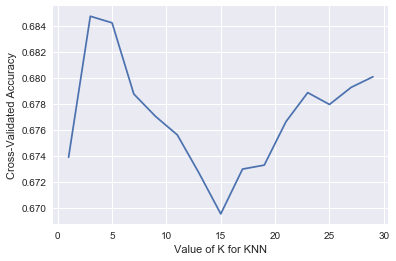

2

In [ ]:
y = labeled.iloc[:, 0]
X = labeled.drop(labeled.columns[0], axis=1)

k = 1
k = 3
k = 5
k = 7
k = 9
k = 11
k = 13
k = 15
k = 17
k = 19
k = 21
k = 23
k = 25
k = 27
k = 29


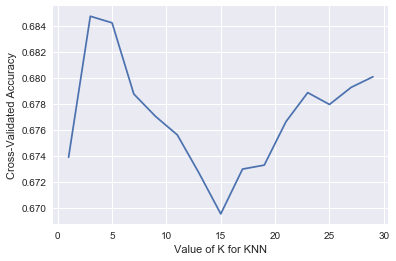

In [135]:
new_best_k = KNN_cv(labeled)

In [140]:
final_model = KNeighborsClassifier(n_neighbors=new_best_k)
final_model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [141]:
sum(final_model.predict(X_future) == y_future)

12383

In [132]:
sum(current_model.predict(X_future) == y_future)

12435

In [133]:
sum(initial_model.predict(X_future) == y_future)

12161